# Wykrywanie krawędzi z wykorzystaniem filtra Sobela
<br>
Wykorzystaną przez nas metodą wykrywanie krawędzi jest zastowanie filtra Sobela (zwanego także operatorem Sobela lub operatorem Sobela-Feldmana).

## Wstęp teoretyczny
Aby wykorzystywać filtr Sobela najpierw konwertuje się obraz na skalę szarości (można używać filtr Sobela na obrazie kolorowym, ale wtedy otrzyma się osobne krawędzie dla 3 kanałów - **R**(czerwonego), **G**(zielonego), **B**(niebieskiego)). Kolejnym etapm jest zamiana obrazu na macież pikseli. 
<br>
Za pomocą filtra Sobela można filtrować krawędzie w różnych kierunkach - poziomym i pionowym (można także filtrować krawędzie ukośne, natomiast najczęściej używa się pionowego i poziomego).
Aby przefiltrować krawędzie we wszystkich kierunkach należy wykonać splot otrzymanych wyników z filtracji pionowej i poziomej.

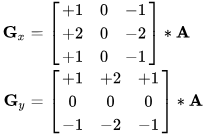

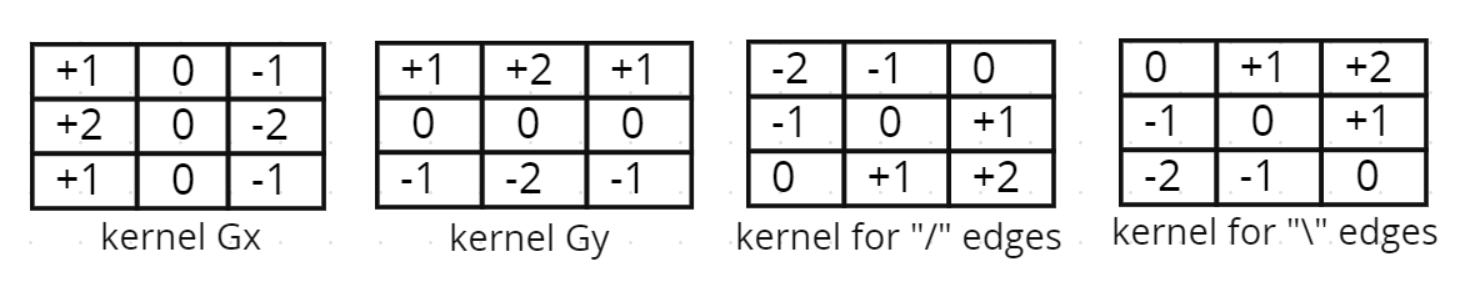

Można zauważyć, że z jednej strony kernela wartości są dodatnie, a z drugiej ujemne. 
<br>
Różnica polega na tym, że jeśli po lewej są wartości dodatnie (**kernel_1**) to jest bardziej wrażliwy gdy zmiana jasności przechodzi od ciemnego do jasnego z lewej do prawej.
<br>
Natomiast jeśli po lewej są wartości ujemne (**kernel_2**), to jest bardziej wrażliwy gdy zmiana jasności przechodzi od jasnego do ciemnego z lewej do prawej.
<br>
Różnica między nimi pokazana jest poniżej (poniżej kodu, którego wynikiem jest poniższy obrazek).

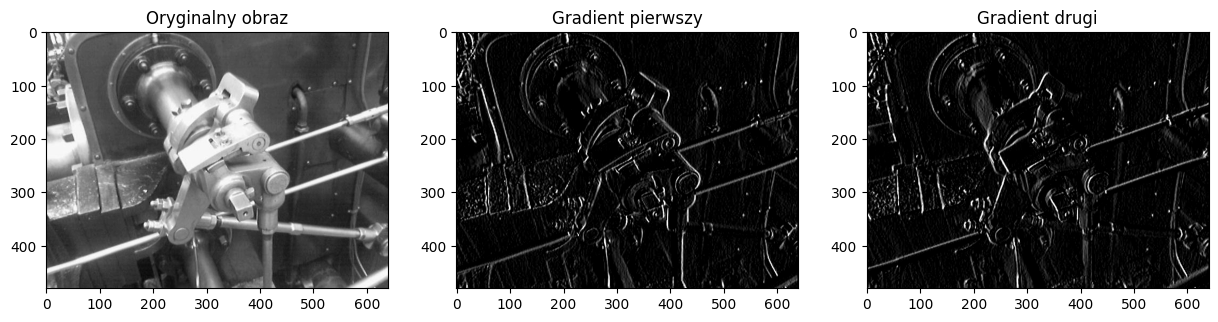

Nie ma to znaczenia po której stronie są ujemne, a po której dodatnie jeśli filtrujemy krawędzie w obu kierunkach (ponieważ i tak podnosimy wynik do kwadratu) [na ten temat więcej informacji niżej] .
<br>
<br>
Kernel **Gx** służy do wykrywania **pionowych** krawędzi (zmiany jasności w kierunku poziomym), a kernel **Gy** służy do wykrywania **poziomych** krawędzi (zmiany jasności w kierunku pionowym).
<br><br>

Filtr Sobela oblicza aproksymację gradientu intensywności obrazu za pomocą dwóch macierzy 3x3, które są stosowane osobno w poziomym (Gx) i pionowym (Gy) kierunku. Następnie te dwa gradienty są łączone, aby uzyskać ogólny obraz gradientu.
<br><br>
Konwolucja: Każda z macierzy (Gx i Gy) jest konwolutowana z obrazem. Konwolucja polega na przesuwaniu macierzy filtru po obrazie, obliczaniu sumy iloczynów elementów macierzy i odpowiadających im pikseli obrazu, a następnie przypisaniu tej wartości do odpowiedniego piksela w wyniku
<br><br>


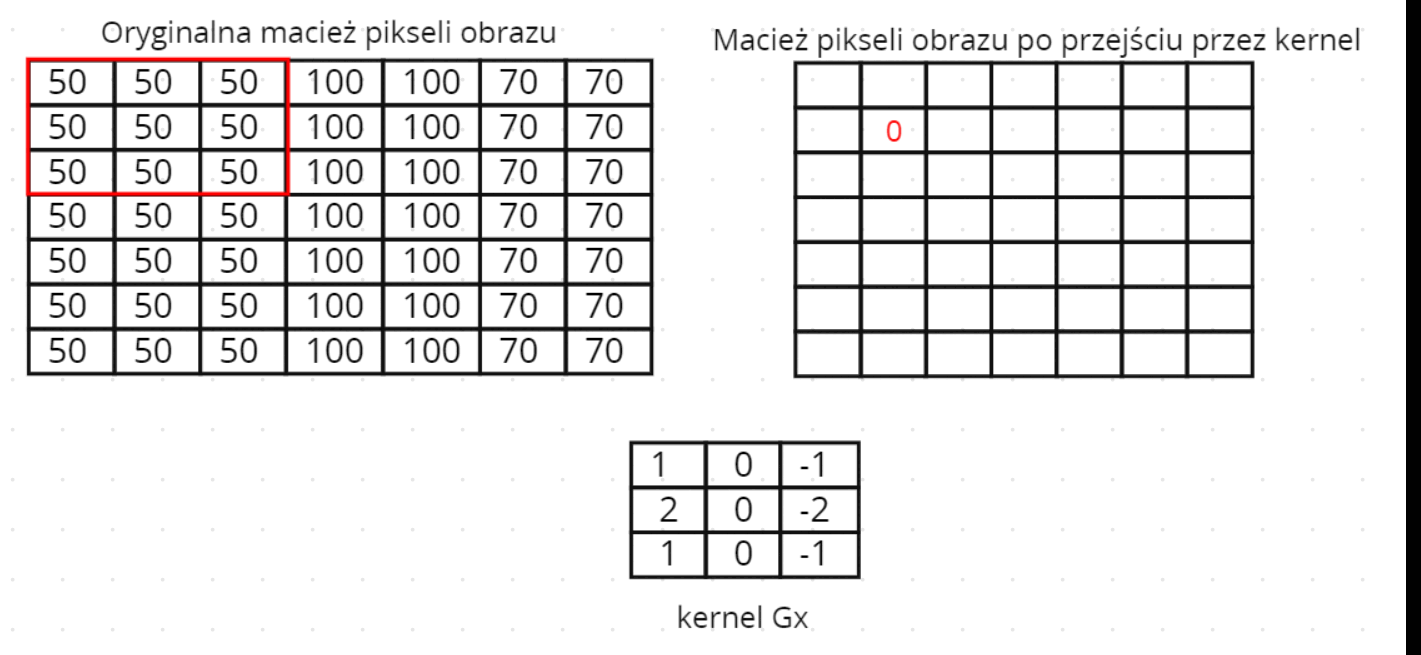

Jak widać powyżej krawędzie wyjściowej macieży są puste. Jednym ze sposobów aby temu zaradzić jest wykorzystanie takich samych wartości jak w polach sąsiednich, gdy kernel "wystaje" poza macierz obrazu (pokazano poniżej).

<!-- 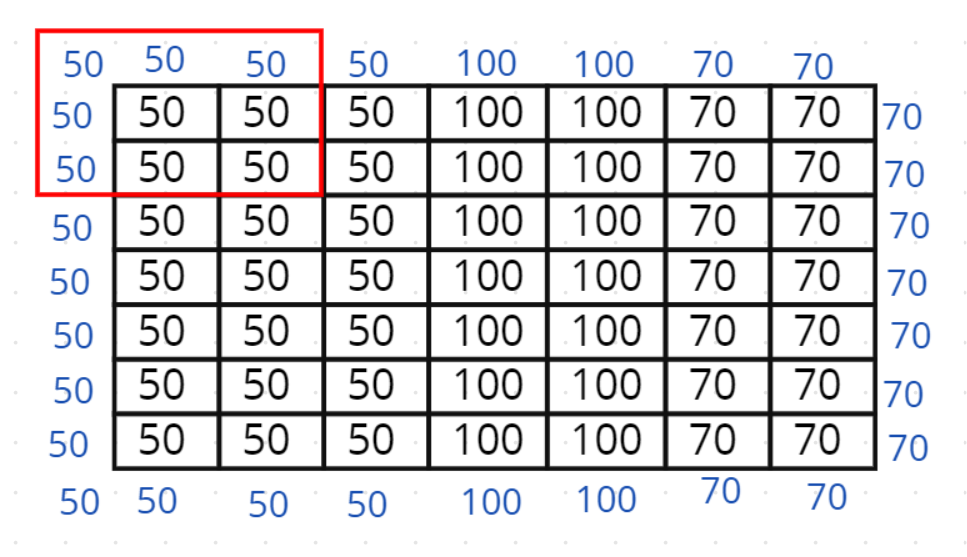 -->
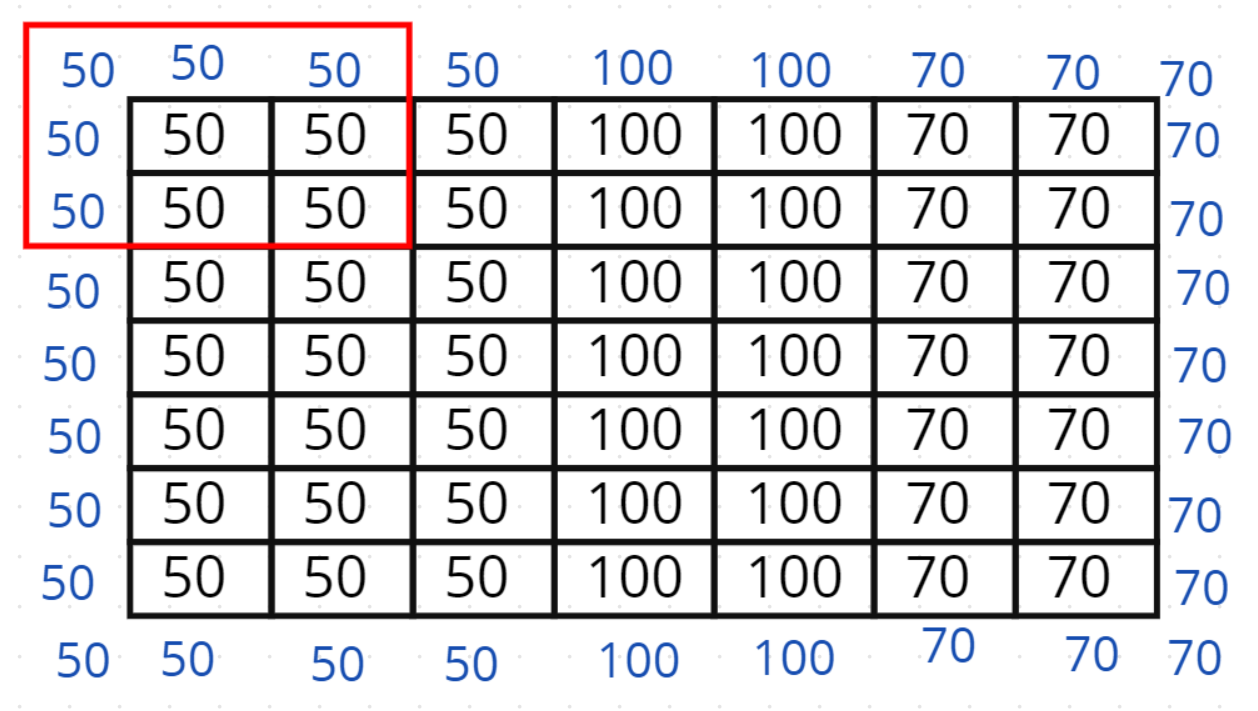

Wykrywanie krawędzi w obu kierunkach robi się w ten sam sposób jak w jednym kierunku z tą różnicą, że nie wpisyje się odrazu wyniku do macieży wyjściowej (jak było to pokazane wyżej). Otrzymane wyniki z kerneli Gx i Gy podnosi się do kwardatu, dodaje, a następnie pierwiastkuje (według wzoru poniżej).

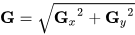

Tak otrzymany wynik wpisuje się do tabeli wyjściowej
<br><br>
Można także do wartości z macierzy wyjściowych z kreneli Gx i Gy zasosować powyższy wzór i wpisać te dane do trzeciej macierzy.
<br><br>
Poniżej porównanie wyjściowych gradientów po przepuszczeniu przez kernel Gx, Gy oraz po połączeniu obu.
<br><br>



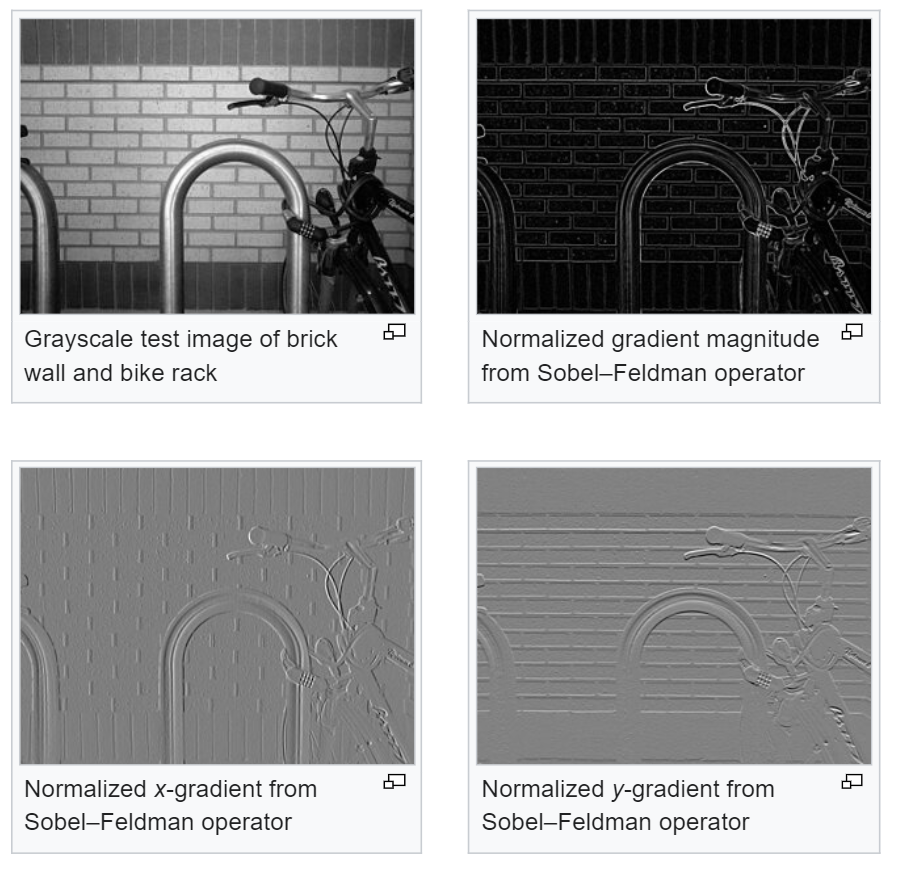

<br><br>
Czasem dla lepszego efektu przed zastosowaniem filtra Sobela "przepuszcza się" obraz przez filtr Gaussa. Powoduje to wygładzenie obrazu, dzięki czemu różne artefakty na zdjęciu nie są traktowane jako krawędzie.
<br><br><br>

## Nasza implementacja filtra Sobela
Do filtracji obrazu filtrem Sobela wykorzystaliśmy Jupyter Notebook oraz FPGA Kria KV260.
<br><br>
Wybrany obraz wgrywamy do Jupyter'a. W nim zamieniamy obraz na tablicę numpy z surowymi danymi (macierz pikseli).
<br>
Takie dane są przesyłane do FPGA, które sprzętowo dokonuje konwersji RGB na skalę szarości oraz filtracji Sobela, a następnie przesyła dane do Jupyter'a.
<br>
Wejściowy oraz wyjściowy obraz prezentowane są w Jupyter'ze.
<br><br>


### Poniżej znajduje się implementacja
<br>


In [1]:
from PIL import Image
from pynq import allocate, Overlay
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#image_file = 'original_image.png'
#image_file = 'star.png'
image_file = 'car.png'

gamma_mul = 1.1 #range from 0.0 to 2.55

with Image.open(image_file) as img:
    IMAGE_WIDTH, IMAGE_HEIGHT = img.size

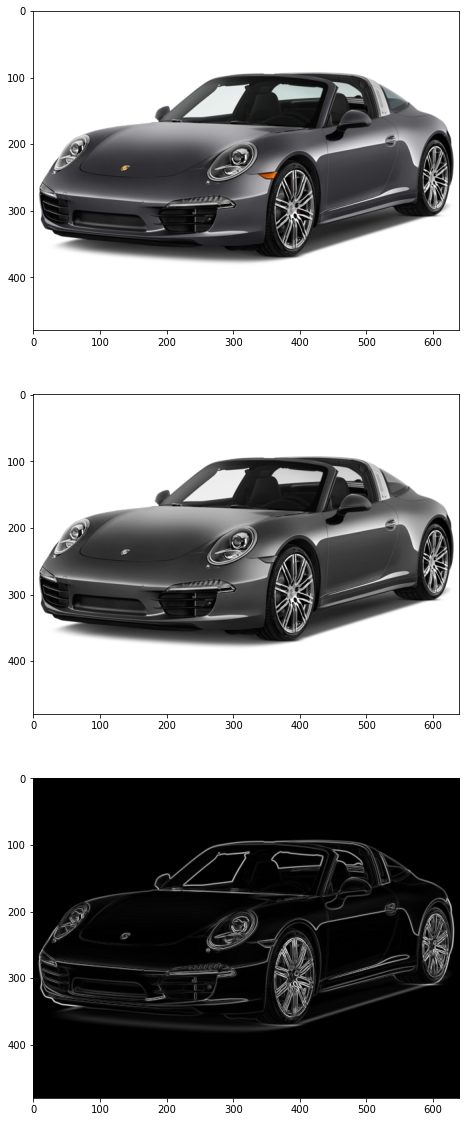

In [3]:
input_image = plt.imread(image_file)

r_img, g_img, b_img = input_image[:, :, 0], input_image[:, :, 1], input_image[:, :, 2]

gamma = 1.4
r_const, g_const, b_const = 0.2126, 0.7152, 0.0722
grayscale_image = r_const * r_img * gamma + g_const * g_img * gamma + b_const * b_img * gamma

"""
     |                 |                 |                  |
     | 1.0   0.0  -1.0 |                 |  1.0   2.0   1.0 |
Gx = | 2.0   0.0  -2.0 |    and     Gy = |  0.0   0.0   0.0 |
     | 1.0   0.0  -1.0 |                 | -1.0  -2.0  -1.0 |
     |                 |                 |                  |
"""

Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])

[rows, columns] = np.shape(grayscale_image)
sobel_filtered_image = np.zeros(shape=(rows, columns))

for i in range(rows - 2):
    for j in range(columns - 2):
        gx = np.sum(np.multiply(Gx, grayscale_image[i:i + 3, j:j + 3]))
        gy = np.sum(np.multiply(Gy, grayscale_image[i:i + 3, j:j + 3]))
        sobel_filtered_image[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)

fig = plt.figure(figsize=(20, 20)) 
   
fig.add_subplot(3, 1, 1) 
plt.imshow(input_image) 
fig.add_subplot(3, 1, 2) 
plt.imshow(grayscale_image, cmap=plt.get_cmap('gray')) 
fig.add_subplot(3, 1, 3)  
plt.imshow(sobel_filtered_image, cmap=plt.get_cmap('gray'))
plt.show()

# plt.imsave('sobel_filtered_image.png', sobel_filtered_image, cmap=plt.get_cmap('gray'))


In [4]:
def convert_png_to_raw(jpg_path):
    
    img = Image.open(jpg_path)

    img_array = np.array(img)
    
    raw_rgb_data = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint32)
    
    raw_rgb_data = img_array[:, :, 0] + (img_array[:, :, 1] << 8) + (img_array[:, :, 2] << 16) + (np.uint8(gamma_mul* 100) << 24)
    
    return raw_rgb_data

In [5]:
sobel_filter_ov = Overlay("sobel_design_wrapper.xsa")

In [6]:
sobel_filter_ov?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff63ea0b20>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay sobel_design_wrapper.xsa. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchies as attributes in the
overlay. If no other

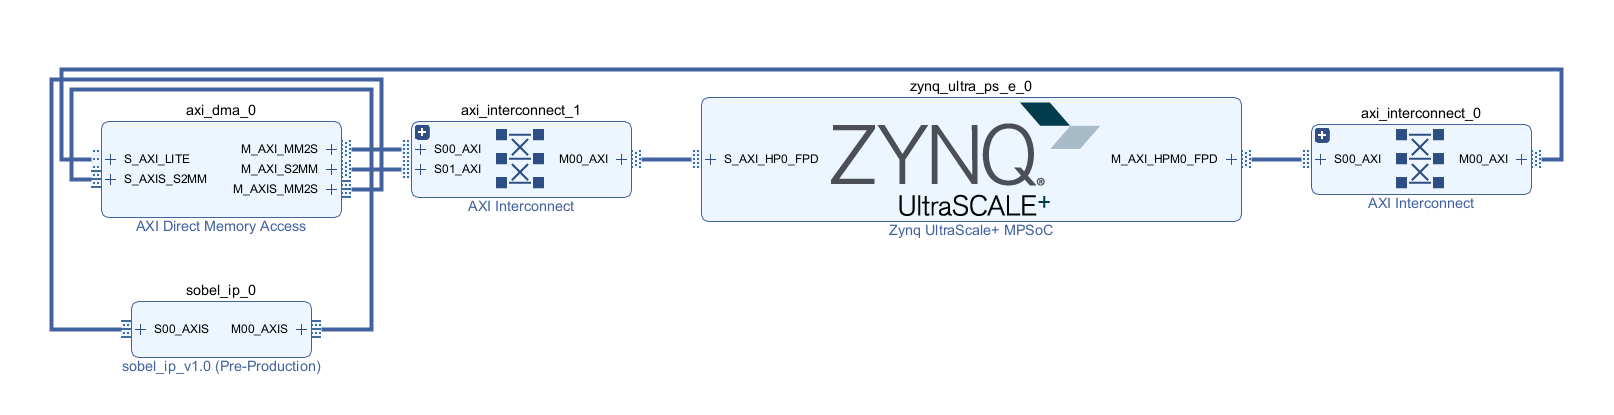

In [7]:
dma = sobel_filter_ov.axi_dma_0

In [8]:
in_buffer = allocate(shape=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                           dtype=np.uint32, cacheable=1)
out_buffer = allocate(shape=(IMAGE_HEIGHT, IMAGE_WIDTH),
                            dtype=np.uint32, cacheable=1)

In [9]:
data_to_send = convert_png_to_raw(image_file)
in_buffer[:] = np.array(data_to_send)

In [10]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [11]:
run_kernel()
print(out_buffer)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


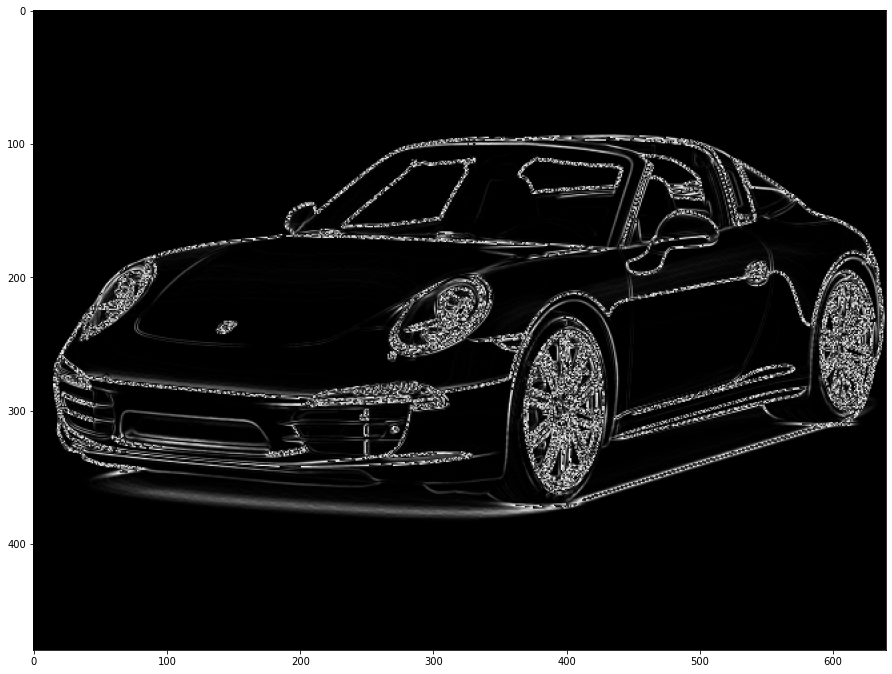

In [12]:
mode = 'L'  # 'L' - grayscale
tablica_uint8 = out_buffer.astype(np.uint8)
img = Image.fromarray(tablica_uint8, mode=mode)
fig = plt.figure(figsize=(40, 40))
   
fig.add_subplot(3, 1, 1)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img.save('output_image.png', 'PNG')

In [13]:
del in_buffer
del out_buffer